In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
import os
import re
import pandas as pd
from collections import defaultdict
import matplotlib.colors as mcolors


# --- COLOR SPACE UTILITIES ---
def hex_to_rgb(hex_color):
    return [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]

def f(t):
    delta = 6/29
    return np.where(t > delta**3, np.cbrt(t), (t / (3 * delta**2)) + (4/29))

def inv_f(t):
    delta = 6/29
    return np.where(t > delta, t**3, 3 * delta**2 * (t - 4/29))

def inv_gamma_correct(c):
    return np.where(c <= 0.0031308, 12.92 * c, 1.055 * np.power(c, 1/2.4) - 0.055)

def lab_normalize(lab):
    return (lab + np.array([0, 128, 128])) / np.array([100, 255, 255])

def lab_unnorm(lab):
    return lab * np.array([100, 255, 255]) - np.array([0, 128, 128])

def lab_to_rgb(lab):
    L, a, b = lab
    fy = (L + 16) / 116
    fx = fy + a / 500
    fz = fy - b / 200
    xyz = np.array([
        0.95047 * inv_f(fx),
        1.00000 * inv_f(fy),
        1.08883 * inv_f(fz)
    ])
    rgb_lin = np.array([
        3.2406 * xyz[0] - 1.5372 * xyz[1] - 0.4986 * xyz[2],
        -0.9689 * xyz[0] + 1.8758 * xyz[1] + 0.0415 * xyz[2],
        0.0557 * xyz[0] - 0.2040 * xyz[1] + 1.0570 * xyz[2]
    ])
    rgb = inv_gamma_correct(np.clip(rgb_lin, 0, 1))
    return np.clip(rgb, 0, 1)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def convert_lab(image):
    mask = image > 0.04045
    img_linear = np.where(mask, ((image + 0.055) / 1.055) ** 2.4, image / 12.92)
    R, G, B = img_linear[..., 0], img_linear[..., 1], img_linear[..., 2]
    X = (0.4124564 * R + 0.3575761 * G + 0.1804375 * B) / 0.950489
    Y = (0.2126729 * R + 0.7151522 * G + 0.0721750 * B) / 1.0
    Z = (0.0193339 * R + 0.1191920 * G + 0.9503041 * B) / 1.088840
    X, Y, Z = f(X), f(Y), f(Z)
    L = 116.0 * Y - 16.0
    a = 500.0 * (X - Y)
    b = 200.0 * (Y - Z)
    return np.stack([L, a, b], axis=-1)

def make_dataset():
    basedir = "/home/drabcio/Pobrane/OneDrive_1_26.04.2025//Res_ColorPickerCustomPicker"
    df = pd.DataFrame(columns=["file","image","colors"])

    for file in os.listdir(basedir):
        filepath = os.path.join(basedir, file)
        if re.match(r".*\d{2}\.txt", file):
            with open(filepath, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts: continue
                    image = parts[0]
                    colors = [c.strip(",") for c in parts[1:]]
                    colors = [c.replace('#','') for c in colors]
                    df = pd.concat([df, pd.DataFrame({"file": file, "image": image, "colors": colors})], ignore_index=True)
    return df

def hex_to_rgb_tuple(hex_color):
    return mcolors.to_rgb(hex_color)

2025-06-11 11:41:51.399641: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 11:41:51.402706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 11:41:51.409873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749634911.421518  158955 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749634911.424951  158955 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749634911.437896  158955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
import numpy as np
# Test Lab conversion
rgb_color = np.array([0.5, 0.2, 0.8]) # Example RGB color
lab_color = convert_lab(rgb_color)
print(f"RGB: {rgb_color}")
print(f"Lab: {lab_color}")

# Convert back to RGB to check
rgb_back = lab_to_rgb(lab_color)
print(f"RGB back from Lab: {rgb_back}")

# Test normalization and unnormalization
normalized_lab = lab_normalize(lab_color)
print(f"Normalized Lab: {normalized_lab}")

unnormalized_lab = lab_unnorm(normalized_lab)
print(f"Unnormalized Lab: {unnormalized_lab}")

# Test with hex
hex_color = "ff0000" # Red
rgb_from_hex = hex_to_rgb(hex_color)
print(f"Hex: {hex_color}, RGB from hex: {rgb_from_hex}")

# Test hex to rgb tuple
rgb_tuple_from_hex = hex_to_rgb_tuple("#"+hex_color)
print(f"Hex: {hex_color}, RGB tuple from hex: {rgb_tuple_from_hex}")

# Test rgb to hex
hex_from_rgb = rgb_to_hex(rgb_from_hex)
print(f"RGB: {rgb_from_hex}, Hex from RGB: {hex_from_rgb}")

RGB: [0.5 0.2 0.8]
Lab: [ 40.04429601  60.25375574 -65.67457626]
RGB back from Lab: [0.49997055 0.20007704 0.79992792]
Normalized Lab: [0.40044296 0.73825002 0.24441343]
Unnormalized Lab: [ 40.04429601  60.25375574 -65.67457626]
Hex: ff0000, RGB from hex: [1.0, 0.0, 0.0]
Hex: ff0000, RGB tuple from hex: (1.0, 0.0, 0.0)
RGB: [1.0, 0.0, 0.0], Hex from RGB: #ff0000


In [5]:
# --- DATA PREPARATION ---
# Load and process your dataframe

df = make_dataset()

df_grouped = df.groupby('image')['colors'].apply(list).reset_index()
df_grouped['lab'] = df_grouped['colors'].apply(
    lambda colors: np.mean([convert_lab(np.array(hex_to_rgb(c))) for c in colors], axis=0)
)
df_grouped['target_rgb'] = df_grouped['colors'].apply(
    lambda colors: np.mean([hex_to_rgb(c) for c in colors], axis=0)
)
basedir = "/home/drabcio/Pobrane/OneDrive_1_26.04.2025//PhotosColorPicker/"
#df_grouped['lab'] = df_grouped['target_rgb'].apply(convert_lab)
df_grouped['image_path'] = basedir + df_grouped['image']
print(df_grouped)

# Load image tensors
def load_image(path):
    img = load_img(path, target_size=(64, 64))
    rgb_norm = img_to_array(img) / 255.0
    lab = convert_lab(rgb_norm)
    return lab_normalize(lab)

image_tensors = tf.stack([load_image(path) for path in df_grouped['image_path']])
labs = np.stack(df_grouped['lab'].values)
labels = np.array(lab_normalize(labs).astype(np.float64))
# labels = np.array(df_grouped['target_rgb'].values.tolist(), dtype=np.float64)

# print("im:",image_tensors)
# print("lb:",labels)

# TF dataset
dataset = tf.data.Dataset.from_tensor_slices((image_tensors, labels)).shuffle(buffer_size=len(image_tensors))
val_size = int(0.2 * len(image_tensors))
train_dataset = dataset.skip(val_size).batch(32)
val_dataset = dataset.take(val_size).batch(32)

               image                                             colors  \
0   000000010432.jpg  [af885a, af7a3e, FFFFFF, 998b49, 636668, 5e8e5...   
1   000000014824.jpg  [6a67c9, 6666c9, 4a49c9, 6869c9, 4d50c9, 7833c...   
2   000000022423.jpg  [b4c9a1, b5d695, cfced6, bfd698, d4d2d6, d5d6b...   
3   000000023019.jpg  [ba78b6, aa74ba, ba6c42, ba65af, ba6628, 696b6...   
4   000000029255.jpg  [5951c6, 543bc6, 5e4b20, 4736aa, 5e4c1f, 6776a...   
..               ...                                                ...   
81  000000537131.jpg  [936244, 936342, 7a9393, 936c50, 7d7f93, 934a0...   
82  000000547938.jpg  [aa9e4e, aa9f47, 97aa7d, aa8548, 84aa63, aa977...   
83  000000556123.jpg  [89a38f, 87a390, 9aa38e, 86a38c, 9aa38d, 9a9fa...   
84  000000562160.jpg  [af501d, af6019, 7e8faf, af5e19, 8a92af, af260...   
85  000000572756.jpg  [b38fbf, ad8bbf, aeb0bf, b781bf, 9c9dbf, 8e96b...   

                                                  lab  \
0   [64.14435283600555, -11.01801416118222

2025-06-11 11:42:03.669691: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# --- MODEL DEFINITION ---
model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])

# model = models.Sequential([
#     layers.Input(shape=(64, 64, 3)),
#     layers.Conv2D(32, (7, 7), activation='relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D(4, 4),
#     layers.Flatten(),
#     layers.Dense(3*256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3, activation='sigmoid')  # Predict L, a, b
# ])
# !

# model = models.Sequential([
# layers.Input(shape=(64, 64, 3)),
# layers.Conv2D(32, (3, 3), activation='relu'),
# layers.MaxPooling2D((2, 2)),
# layers.Conv2D(64, (3, 3), activation='relu'),
# layers.MaxPooling2D((2, 2)),
# layers.Flatten(),
# layers.Dense(128, activation='relu'),
# layers.Dense(3, activation='sigmoid') # RGB values between 0 and 1
# ])

model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True, learning_rate=10**-3), loss='mse')
model.fit(train_dataset, epochs=15, validation_data=val_dataset)



Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0458 - val_loss: 0.0243
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0125 - val_loss: 0.0107
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034 - val_loss: 0.0021
E

In [7]:
# --- EVALUATION ---
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

def mae(predictions, truth):
    return np.mean(np.abs(predictions - truth))

def rmse(predictions, truth):
    return np.sqrt(np.mean((predictions - truth)**2))

def safe_compare(predictions, truth):
    eps = 1e-6
    return np.mean(np.abs(predictions - truth) / (np.abs(truth) + eps), axis=0)

all_preds = model.predict(tf.data.Dataset.from_tensor_slices(image_tensors).batch(32))
val_predicts = model.predict(val_dataset)
print("Compare %:", safe_compare(val_predicts, labels[:len(val_predicts)]) * 100)
print("MAE:", mae(val_predicts, labels[:len(val_predicts)]))
print("RMSE:", rmse(val_predicts, labels[:len(val_predicts)]))


for i in range(5):
    p = (((val_predicts[i])))
    t = ((labels[i]))
    print("Predicted:", rgb_to_hex(p), "True:", rgb_to_hex(t))
# --- PREDICTION VISUALIZATION ---
def show_colors(hex_list, titles=None):
    fig, ax = plt.subplots(1, len(hex_list), figsize=(len(hex_list) * 2, 2))
    if len(hex_list) == 1:
        ax = [ax]
    for i, hex_color in enumerate(hex_list):
        rgb = np.array([[hex_to_rgb_tuple(hex_color)]])
        ax[i].imshow(rgb)
        ax[i].axis("off")
        if titles:
            ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Compare %: [18.64605183 14.09377208 21.92782051]
MAE: 0.09575257472589438
RMSE: 0.11960188580279739
Predicted: #9b8684 True: #a374a9
Predicted: #928b8d True: #7ea471
Predicted: #8a916c True: #a47091
Predicted: #899664 True: #799476
Predicted: #b566b1 True: #829461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Lab true: [ 50.32086687  13.00972023 -34.23091913]
Predicted color: #8b79ab
True color: #6b73b1


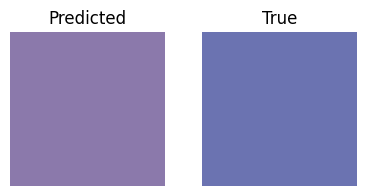

In [10]:
# Predict on new image
image_path = "/home/drabcio/Pobrane/OneDrive_1_26.04.2025/PhotosColorPicker/000000452354.jpg"
image = load_img(image_path, target_size=(64, 64))
img_array = img_to_array(image) / 255.0
lab_image = convert_lab(img_array)
lab_normed = lab_normalize(lab_image)
input_arr = np.expand_dims(lab_normed, axis=0)
prediction = model.predict(input_arr)[0]
lab_pred = lab_unnorm(prediction)
rgb_pred = lab_to_rgb(lab_pred)
pred_hex = rgb_to_hex(rgb_pred)

true_rgb = lab_to_rgb(df_grouped[df_grouped['image'] == "000000452354.jpg"]["lab"].values[0])
true_hex = rgb_to_hex(true_rgb)
print("Lab true:", df_grouped[df_grouped['image'] == "000000452354.jpg"]["lab"].values[0])
print("Predicted color:", pred_hex)
print("True color:", true_hex)
show_colors([pred_hex, true_hex], ["Predicted", "True"])



#1 lipca - 3 miesiące, kwestionarusz